In [3]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, log_loss, precision_score, precision_recall_curve
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import classification_report

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from timeit import default_timer as timer
from tqdm.notebook import tqdm


In [4]:
data = pd.read_csv("/data/work/wessex/Wessex/test/Brunel_track_seeds_with_target.csv")
target = data.particle_isDown_noVelo 
features = data.drop(["Unnamed: 0", 
                      "Unnamed: 0_x", # index
                      "Unnamed: 0_y",
                      "eventID",
                      "particle_key",
                      "particle_hasUT",
                      "particle_pid", # this are MC info
                      "particle_hasScifi",
                      "particle_isDown_noVelo",
                      "particle_isDown",
                      "particle_hasVelo",
                      "track_charge",
                      "track_position_z",
                     ], axis=1)
features.head()

,track_phi,track_tx,track_ty,track_nLHCbIDs,track_p,track_chi2,track_position_x,track_position_y,track_chi2PerDoF,track_pt,track_pseudoRapidity,track_position_r,track_position_phi
0,2.849378,-0.343474,0.103326,12.0,2020.072174,6.275086,494.515198,1124.644897,0.896441,682.012956,1.749189,7599.958646,1.156534
1,-3.082239,-0.358948,-0.021330,12.0,3841.771978,1.360128,-1080.491943,-141.657471,0.194304,1299.941130,1.746825,7578.755154,-3.011232
2,-0.011027,0.096606,-0.001065,11.0,11831.335600,1.228229,235.222702,-5.106698,0.204705,1137.754221,3.032522,7503.689479,-0.021707
3,3.105371,-0.442834,0.016047,9.0,1982.935289,1.397992,-256.822998,115.813004,0.349498,803.347165,1.552877,7505.289515,2.717953
4,-3.125277,-0.170356,-0.002780,11.0,6950.099982,1.731246,-439.475525,-42.887833,0.288541,1167.325690,2.470060,7512.987296,-3.044312


In [5]:
target

0          False
1          False
2          False
3          False
4          False
           ...  
6431432    False
6431433    False
6431434    False
6431435    False
6431436    False
Name: particle_isDown_noVelo, Length: 6431437, dtype: bool

In [6]:
target =  target.astype(int)

In [7]:
def create_sampler(target):
    class_sample_count = np.array(
        [len(np.where(target == t)[0]) for t in np.unique(target)])
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in target])
    samples_weight = torch.from_numpy(samples_weight)
    samples_weigth = samples_weight.double()
    return torch.utils.data.sampler.WeightedRandomSampler(samples_weight, len(samples_weight))




In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [9]:
X_train, X_valid, Y_train, Y_valid = train_test_split(features, target, test_size=0.2, random_state=12)

In [10]:
X_valid = (X_valid - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

In [11]:
datasets={
    "train":TensorDataset(torch.Tensor(np.array(X_train.values)).to(device), torch.Tensor(np.array(Y_train.values, dtype=np.uint8)).to(device)),
    "valid":TensorDataset(torch.Tensor(np.array(X_valid.values)).to(device), torch.Tensor(np.array(Y_valid.values, dtype=np.uint8)).to(device))
}


In [12]:
datasets["valid"].__getitem__(0)

(tensor([ 5.5752e-02,  6.0465e-01,  3.2267e-01,  7.1693e-01, -3.9098e-03,
         -5.5659e-01,  7.8569e-01,  2.9878e-01, -5.9557e-01, -3.3483e-04,
         -1.3694e-01, -3.9947e-01,  1.2029e-01], device='cuda:0'),
 tensor(0., device='cuda:0'))

In [13]:
dataloaders = { 
    'train':DataLoader(datasets["train"],
                   sampler=create_sampler(Y_train),
                   batch_size=128,
                   shuffle=False,
                    num_workers=0),
    'valid':DataLoader(datasets["valid"],
                      batch_size=128,
                      shuffle=False,
                      num_workers=0)
}

In [14]:
for batch in dataloaders["train"]:
    print("features", batch[0], len(batch[0]))
    print("target", batch[1], len(batch[1]))
    break

features tensor([[ 0.0911,  0.7758,  0.6955,  ..., -0.4164, -0.2706,  0.2194],
        [ 0.0074,  1.5782,  0.0473,  ..., -1.1503, -0.1537, -0.0032],
        [ 1.5061, -1.0437,  0.4770,  ..., -0.6511, -0.1982,  1.4824],
        ...,
        [ 1.4881, -0.9481,  0.5955,  ..., -0.5454, -0.1836,  1.4574],
        [ 0.8796, -0.0691,  0.8318,  ...,  1.3504, -0.6208,  0.6384],
        [ 1.4509, -0.1484,  0.1180,  ...,  1.8142, -0.7564,  1.4799]],
       device='cuda:0') 128
target tensor([1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0.,
        1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1.,
        1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
        0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0.,
        0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1.,
        0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1.,
        1., 1., 1., 0., 1., 0., 1., 1., 1.

In [15]:
def train_and_valid_classification(model,
                                   criterion,
                                   optimizer,
                                   run_hist={},
                                   num_epochs=10,
                                   save_every_nth_batch_loss=50):
    """Train and evaluate the classification model."""
    if len(run_hist) == 0:
        run_hist = {key: [] for key in ['epoch_loss_train',
                                    'epoch_loss_valid',
                                    'epoch_acc_valid',
                                    'epoch_acc_train',   
                                    'batch_loss_train']}
    process_timer = timer()
    
    for epoch in range(num_epochs):
        print('\nEpoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'valid']:
            start_epoch = timer()
            if phase == 'train':
                model.train()
            else:
                model.eval()
        
            running_loss = 0.0
            running_corrects = 0
            
            batch_iterator = tqdm(iter(dataloaders[phase]), leave=False, total=len(dataloaders[phase]))

        
            for i, batch in enumerate(batch_iterator):
                inputs, labels = batch
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels.long())

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.detach() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data.long())

                if phase == 'train' and i % save_every_nth_batch_loss == 0:
                    run_hist['batch_loss_train'].append(loss.item())

            epoch_loss = running_loss / len(datasets[phase])
            epoch_acc = running_corrects.float() / len(datasets[phase])

            print('{} loss: {:.4f}, {} acc: {:.4f}, elapsed:{:.4f}'.\
            format(phase,
                   epoch_loss.item(),
                   phase,
                   epoch_acc.item(),
                   timer()-start_epoch
                 ))
                 
        
            run_hist['epoch_loss_' + phase].append(epoch_loss.item())
            run_hist['epoch_acc_' + phase].append(epoch_acc.item())

    print("training took: ",timer()- process_timer)    
    return model, run_hist

# Build model with 10 hidden layers

In [16]:
class NHiddenTrackingNetwork(torch.nn.Module):
    def __init__(self, inputs,n_hidden, hidden_dict):
        super(NHiddenTrackingNetwork, self).__init__()
        if n_hidden < 3: 
          raise ValueError("n_hidden must be greater than 2")
        self.input_layer = nn.Linear(inputs, hidden_dict[0])
        self.layers = nn.ModuleList()
        for layer_it in range(n_hidden-1):
          self.layers.append(nn.Linear(hidden_dict[layer_it],
                                       hidden_dict[layer_it+1]))
        self.output_layer = nn.Linear(hidden_dict[n_hidden-1], 2) 
        # initialize layers
        self.layers.apply(self._init_weights)
        self._init_weights(self.output_layer)
                
        
    def forward(self, x):
        x = self.input_layer(x)
        x = F.relu(x)
        for layer in self.layers:
          x = layer(x)
          x = F.relu(x)
        x = self.output_layer(x)
        return x
    
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight)
            m.bias.data.fill_(0.01)




In [17]:
n_hidden = 10
hidden_dict = {hidden: (n_hidden-hidden)*10 for hidden in range(n_hidden)}
hidden_dict

{0: 100, 1: 90, 2: 80, 3: 70, 4: 60, 5: 50, 6: 40, 7: 30, 8: 20, 9: 10}

In [18]:
model = NHiddenTrackingNetwork(X_train.shape[1], n_hidden, hidden_dict).to(device)
model

NHiddenTrackingNetwork(
  (input_layer): Linear(in_features=13, out_features=100, bias=True)
  (layers): ModuleList(
    (0): Linear(in_features=100, out_features=90, bias=True)
    (1): Linear(in_features=90, out_features=80, bias=True)
    (2): Linear(in_features=80, out_features=70, bias=True)
    (3): Linear(in_features=70, out_features=60, bias=True)
    (4): Linear(in_features=60, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=40, bias=True)
    (6): Linear(in_features=40, out_features=30, bias=True)
    (7): Linear(in_features=30, out_features=20, bias=True)
    (8): Linear(in_features=20, out_features=10, bias=True)
  )
  (output_layer): Linear(in_features=10, out_features=2, bias=True)
)

In [19]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())


Model's state_dict:
input_layer.weight 	 torch.Size([100, 13])
input_layer.bias 	 torch.Size([100])
layers.0.weight 	 torch.Size([90, 100])
layers.0.bias 	 torch.Size([90])
layers.1.weight 	 torch.Size([80, 90])
layers.1.bias 	 torch.Size([80])
layers.2.weight 	 torch.Size([70, 80])
layers.2.bias 	 torch.Size([70])
layers.3.weight 	 torch.Size([60, 70])
layers.3.bias 	 torch.Size([60])
layers.4.weight 	 torch.Size([50, 60])
layers.4.bias 	 torch.Size([50])
layers.5.weight 	 torch.Size([40, 50])
layers.5.bias 	 torch.Size([40])
layers.6.weight 	 torch.Size([30, 40])
layers.6.bias 	 torch.Size([30])
layers.7.weight 	 torch.Size([20, 30])
layers.7.bias 	 torch.Size([20])
layers.8.weight 	 torch.Size([10, 20])
layers.8.bias 	 torch.Size([10])
output_layer.weight 	 torch.Size([2, 10])
output_layer.bias 	 torch.Size([2])


In [20]:
trenable_parameters = filter(lambda p: p.requires_grad, model.parameters())
print("n_params", sum([np.prod(p.size()) for p in trenable_parameters]) )

n_params 34872


In [21]:
1- sum(target)/len(target)

0.8552497676646759

In [22]:
1- sum(Y_train)/len(Y_train)

0.855171929909124

In [23]:
1- sum(Y_valid)/len(Y_valid)

0.8555611185053424

In [24]:
criterion = nn.CrossEntropyLoss().cuda()
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [25]:
model, run_hist = train_and_valid_classification(model, criterion, optimizer, num_epochs=10)


Epoch 1/10
----------


train loss: 0.6035, train acc: 0.6610, elapsed:274.5993


valid loss: 0.5801, valid acc: 0.6789, elapsed:22.9260

Epoch 2/10
----------


train loss: 0.5729, train acc: 0.6831, elapsed:265.7470


valid loss: 0.5934, valid acc: 0.6647, elapsed:22.7073

Epoch 3/10
----------


train loss: 0.5666, train acc: 0.6875, elapsed:268.8786


valid loss: 0.5663, valid acc: 0.7029, elapsed:22.9764

Epoch 4/10
----------


train loss: 0.5632, train acc: 0.6903, elapsed:270.7873


valid loss: 0.5696, valid acc: 0.6989, elapsed:25.1891

Epoch 5/10
----------


train loss: 0.5612, train acc: 0.6919, elapsed:271.5306


valid loss: 0.5853, valid acc: 0.6772, elapsed:23.7445

Epoch 6/10
----------


train loss: 0.5602, train acc: 0.6926, elapsed:266.7803


valid loss: 0.5613, valid acc: 0.6998, elapsed:23.0942

Epoch 7/10
----------


train loss: 0.5588, train acc: 0.6937, elapsed:268.7310


valid loss: 0.5657, valid acc: 0.7029, elapsed:22.7066

Epoch 8/10
----------


train loss: 0.5586, train acc: 0.6939, elapsed:268.7220


valid loss: 0.5485, valid acc: 0.7225, elapsed:23.0039

Epoch 9/10
----------


train loss: 0.5578, train acc: 0.6947, elapsed:267.8039


valid loss: 0.5698, valid acc: 0.6905, elapsed:23.0363

Epoch 10/10
----------


train loss: 0.5570, train acc: 0.6952, elapsed:265.7163


valid loss: 0.5589, valid acc: 0.7099, elapsed:23.0983
training took:  2921.783536407631


In [26]:
def print_roc(model, X, Y):
    X = torch.tensor(X.values, dtype=torch.float).to("cpu")
    model.eval
    model.to("cpu")
    output =  model(X)    
    plt.figure(figsize=[6, 6])
    pred = F.softmax(output, dim=1).cpu().detach().numpy()[:,1]
    fpr, tpr, thresholds = roc_curve(Y,pred )
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=1, label='ROC BDT (area = %0.4f)'%(roc_auc))
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='no discrimination')
    plt.xlim([-0.05, 1.05])
    plt.ylim([0.8, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()
    del X



In [27]:
def plot_training_classification(run_hist):
    """Plot the training history of the classification model."""
    fig, ax = plt.subplots(1,2, figsize=(20,6), sharex=True)
    x = np.arange(len(run_hist["epoch_loss_train"])) + 1
    ax[0].plot(x, run_hist["epoch_loss_train"],'b', marker='.', label="train loss")
    ax[0].plot(x, run_hist["epoch_loss_valid"],'r', marker='.', label="valid loss")
    ax[0].legend()
    ax[1].plot(x, run_hist["epoch_acc_train"],'b', marker='.', label="train accuracy")
    ax[1].plot(x, run_hist["epoch_acc_valid"],'r', marker='.', label="valid accuracy")
    ax[1].legend()


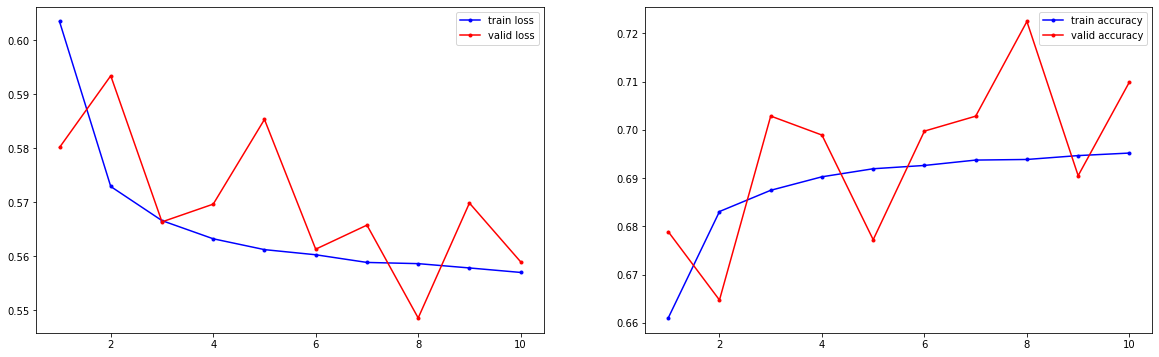

In [28]:
plot_training_classification(run_hist)

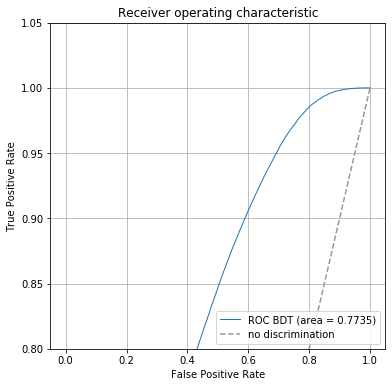

In [29]:
print_roc(model,X_valid, Y_valid )

In [30]:
for param in model.named_parameters():
  print(param)


('input_layer.weight', Parameter containing:
tensor([[-0.0769,  0.2308,  0.2395,  ..., -0.0846, -0.0774, -0.1619],
        [ 0.0119,  0.3154,  0.2168,  ..., -0.1007,  0.0751,  0.1299],
        [ 0.0103,  0.0261,  0.0843,  ...,  0.0197, -0.2323,  0.2103],
        ...,
        [-0.0686, -0.1370,  0.2498,  ..., -0.0766, -0.1605, -0.0387],
        [ 0.0401,  0.1701, -0.2398,  ..., -0.0051, -0.0311,  0.2672],
        [-0.0567, -0.3250,  0.0175,  ..., -0.1672, -0.2572, -0.1019]],
       requires_grad=True))
('input_layer.bias', Parameter containing:
tensor([-0.0900, -0.0185, -0.1366,  0.0793, -0.2042,  0.0108,  0.0291, -0.1414,
        -0.0305, -0.1471, -0.3556,  0.0415,  0.1452, -0.1485, -0.3490,  0.2186,
        -0.2817, -0.1298, -0.0049,  0.2254, -0.0883, -0.0838, -0.3255,  0.1336,
        -0.0933, -0.1703, -0.1484,  0.0836,  0.1223,  0.2184, -0.1044, -0.2617,
         0.0744, -0.2037, -0.2057,  0.0100,  0.0584, -0.2288,  0.1674,  0.1405,
        -0.2534,  0.1650,  0.1751, -0.2135,  0.182

In [31]:
torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'run_history':run_hist,
            }, ".19NN.pt")


In [32]:
model.to(device)

NHiddenTrackingNetwork(
  (input_layer): Linear(in_features=13, out_features=100, bias=True)
  (layers): ModuleList(
    (0): Linear(in_features=100, out_features=90, bias=True)
    (1): Linear(in_features=90, out_features=80, bias=True)
    (2): Linear(in_features=80, out_features=70, bias=True)
    (3): Linear(in_features=70, out_features=60, bias=True)
    (4): Linear(in_features=60, out_features=50, bias=True)
    (5): Linear(in_features=50, out_features=40, bias=True)
    (6): Linear(in_features=40, out_features=30, bias=True)
    (7): Linear(in_features=30, out_features=20, bias=True)
    (8): Linear(in_features=20, out_features=10, bias=True)
  )
  (output_layer): Linear(in_features=10, out_features=2, bias=True)
)

In [ ]:
model, run_hist = train_and_valid_classification(model, criterion, optimizer,run_hist, num_epochs=20)


Epoch 1/20
----------


train loss: 0.5568, train acc: 0.6954, elapsed:269.8367


valid loss: 0.5577, valid acc: 0.7063, elapsed:23.3102

Epoch 2/20
----------


train loss: 0.5563, train acc: 0.6958, elapsed:269.5248


valid loss: 0.5834, valid acc: 0.6837, elapsed:23.2838

Epoch 3/20
----------


train loss: 0.5561, train acc: 0.6961, elapsed:272.4001


valid loss: 0.5438, valid acc: 0.7207, elapsed:23.1901

Epoch 4/20
----------


train loss: 0.5559, train acc: 0.6962, elapsed:270.3674


valid loss: 0.5505, valid acc: 0.7128, elapsed:23.5331

Epoch 5/20
----------


train loss: 0.5555, train acc: 0.6966, elapsed:270.0912


valid loss: 0.5461, valid acc: 0.7110, elapsed:23.1362

Epoch 6/20
----------


train loss: 0.5553, train acc: 0.6967, elapsed:267.3242


valid loss: 0.5601, valid acc: 0.7003, elapsed:23.1626

Epoch 7/20
----------


train loss: 0.5550, train acc: 0.6969, elapsed:273.8013


valid loss: 0.5571, valid acc: 0.7025, elapsed:22.9319

Epoch 8/20
----------


train loss: 0.5545, train acc: 0.6973, elapsed:269.6865


valid loss: 0.5433, valid acc: 0.7168, elapsed:23.2251

Epoch 9/20
----------


train loss: 0.5543, train acc: 0.6974, elapsed:268.1211


valid loss: 0.5578, valid acc: 0.7042, elapsed:24.3463

Epoch 10/20
----------


train loss: 0.5542, train acc: 0.6976, elapsed:262.0991


valid loss: 0.5581, valid acc: 0.7005, elapsed:22.5105

Epoch 11/20
----------


train loss: 0.5538, train acc: 0.6976, elapsed:259.2155


valid loss: 0.5461, valid acc: 0.7180, elapsed:22.5838

Epoch 12/20
----------


train loss: 0.5539, train acc: 0.6977, elapsed:259.9032


valid loss: 0.5595, valid acc: 0.7067, elapsed:22.3110

Epoch 13/20
----------


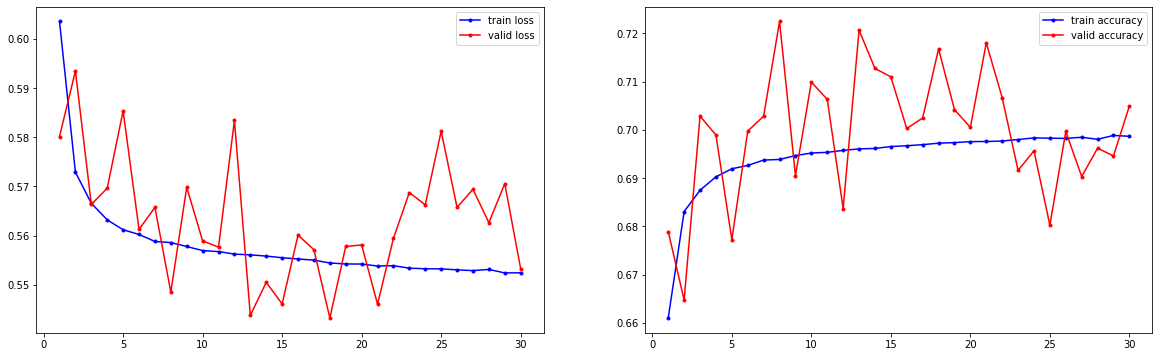

In [42]:
plot_training_classification(run_hist)

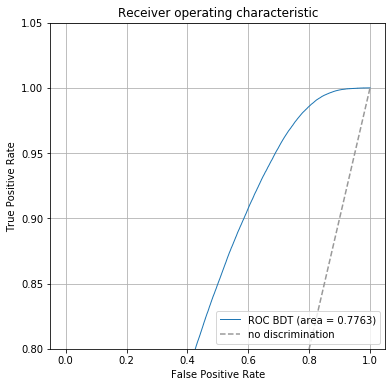

In [41]:
print_roc(model,X_valid, Y_valid )

In [40]:
print_classification_report(model,X_valid, Y_valid, 0.30)

              precision    recall  f1-score   support

       ghost       0.97      0.33      0.50   1100498
        true       0.19      0.94      0.32    185790

   micro avg       0.42      0.42      0.42   1286288
   macro avg       0.58      0.64      0.41   1286288
weighted avg       0.86      0.42      0.47   1286288

